In [1]:
from SYK_fft import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from ConformalAnalytical import *

In [2]:
Nbig = int(1e5)
#Nbig = 10
err = 1e-6

beta = 50
mu = 0
g = 1.0
r = 2.
kappa = 1.

omega = (2 * np.arange(Nbig) - Nbig + 1) * np.pi/beta
nu = (2 * np.arange(Nbig) - Nbig ) * np.pi/beta
tau = (np.arange(Nbig) + 1./2) * beta/Nbig

In [3]:
Gtau = 0.5*np.ones(Nbig)
Dtau = 1.0*DfreeImagtau(tau,r,beta)

itern = 0
diff = 1
x = 0.5
#x=1.0

while(diff>err):
#while(itern<200):
    itern+=1
    diffold = diff
    
    oldGtau = 1.0*Gtau
    oldDtau = 1.0*Dtau
    
    oldGomega = Time2FreqF(oldGtau,Nbig,beta)
    oldDomega = Time2FreqB(oldDtau,Nbig,beta)
    
    Sigmatau = 1.0 * kappa * (g**2) * Dtau * Gtau
    Pitau = 1.0 * g**2 * Gtau * Gtau[::-1] #KMS G(-tau) = -G(beta-tau)
    
    Sigmaomega = Time2FreqF(Sigmatau,Nbig,beta)
    Piomega =  Time2FreqB(Pitau,Nbig,beta)
    
    Gomega = x*(1./(1j*omega + mu - Sigmaomega)) + (1-x)*oldGomega
    Domega = x*(1./(nu**2 + r - Piomega)) + (1-x)*oldDomega
   
    Gtau = Freq2TimeF(Gomega,Nbig,beta)
    Dtau = Freq2TimeB(Domega,Nbig,beta)
    
    #diff = (1.0/Nbig) * np. sqrt(np.sum((np.abs(Gtau-oldGtau))**2) + np.sum((np.abs(Dtau-oldDtau))**2))
    diff = (1.0/Nbig) * np. sqrt(np.sum((np.abs(Gtau-oldGtau))**2) + np.sum((np.abs(Dtau-oldDtau))**2))
    
    if diff>diffold:
        x/=2


    
print("itern = ",itern," , diff = ", diff)
    

itern =  43  , diff =  6.987443270896057e-07


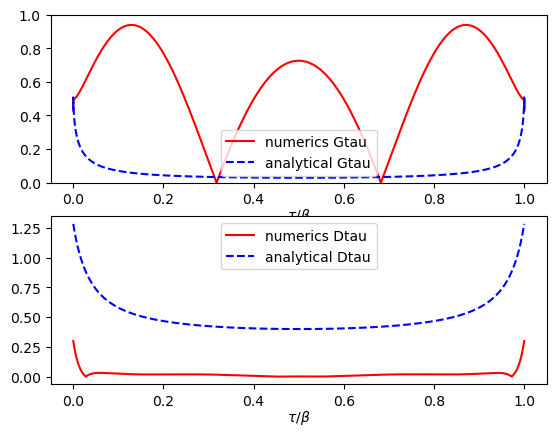

In [4]:
Gconftau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
Dconftau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)
FreeDtau = DfreeImagtau(tau,r,beta)

fig, ax = plt.subplots(2)

ax[0].plot(tau/beta, np.abs(Gtau), 'r', label = 'numerics Gtau')
ax[0].plot(tau/beta, np.abs(Gconftau), 'b--', label = 'analytical Gtau' )
ax[0].set_ylim(0,1)
ax[0].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[0].legend()

ax[1].plot(tau/beta, np.abs(Dtau), 'r', label = 'numerics Dtau')
ax[1].plot(tau/beta, np.abs(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.abs(FreeDtau), 'b--', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[1].legend()
